# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import csv
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import product
from random import randint


from nltk.corpus import gutenberg, stopwords
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier

sns.set(style='ticks', color_codes=True)

# Download the texts
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

# Get MNIST
digit_data = load_digits()['images']
digit_data = digit_data.reshape((len(digit_data), -1))
digit_labels = load_digits()['target']

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\whm0004\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\whm0004\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whm0004\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1.)  Find interesting phrases in Alice In Wonderland.

Most code adapted from module 10 notebook.

In [2]:
# Load the text
sentences = gutenberg.sents('carroll-alice.txt') # returns as a list of lists of strings -_-

# Format the text
stop_list = stopwords.words('english')
term_list = []
for idx, terms in enumerate(sentences):
     # Remove stop words
    terms = [w for w in terms if w not in stop_list]
    
    # Remove 'CHAPTER'
    terms = [w for w in terms if re.search(r'CHAPTER', w) is None]
    
    # Make everything lowercase (reduces total size)
    terms = [w.lower() for w in terms]
        
    # Remove 'said.' I had a bunch of results that were related to 'said'
    # that I didn't think were interesting.
    terms = [w for w in terms if re.search(r'said', w) is None]
    
    # Remove non-words and short words
    terms = [w for w in terms if re.search(r'[A-Za-z]{3,}', w) is not None]
    
    # If we haven't emptied the list of terms,
    if len(terms) > 0:
            
        # add to the list
        term_list.append(terms)

display(term_list[:5])

[['alice', 'adventures', 'wonderland', 'lewis', 'carroll'],
 ['down', 'rabbit', 'hole'],
 ['alice',
  'beginning',
  'get',
  'tired',
  'sitting',
  'sister',
  'bank',
  'nothing',
  'twice',
  'peeped',
  'book',
  'sister',
  'reading',
  'pictures',
  'conversations',
  'use',
  'book',
  'thought',
  'alice',
  'without',
  'pictures',
  'conversation'],
 ['considering',
  'mind',
  'well',
  'could',
  'hot',
  'day',
  'made',
  'feel',
  'sleepy',
  'stupid',
  'whether',
  'pleasure',
  'making',
  'daisy',
  'chain',
  'would',
  'worth',
  'trouble',
  'getting',
  'picking',
  'daisies',
  'suddenly',
  'white',
  'rabbit',
  'pink',
  'eyes',
  'ran',
  'close'],
 ['there',
  'nothing',
  'very',
  'remarkable',
  'alice',
  'think',
  'very',
  'much',
  'way',
  'hear',
  'rabbit',
  'say',
  'dear']]

In [3]:
# Denormalize
trans_list = []
item_names = {}
item_ids = {}

id_counter = 0
for terms in term_list:
    transaction = []
    
    for term in terms:
        if term not in item_ids:
            item_ids[term] = id_counter
            item_names[id_counter] = term
            id_counter += 1
            
        transaction += [item_ids[term]]
    
    trans_list += [transaction]
    
len_ids, len_trans = len(item_ids), len(trans_list)
    
items = np.arange(0, len_ids)

# Information
print(f'len_ids={len_ids}, len_trans={len_trans}')

len_ids=2471, len_trans=1672


In [4]:
# Binarize
transactions = np.full((len_trans, len_ids), False, dtype=np.bool)

for idx, trans in enumerate(trans_list):
    for term in trans:
        transactions[idx][term] = True 
        
print(f'{transactions[:10].astype(int)}')

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [5]:
# Make Weka csv
out_file = 'alice.csv'
with open('alice.csv', 'w', newline='') as file:
    csvwriter = csv.writer(file, delimiter=',', quoting=csv.QUOTE_ALL, quotechar="'", lineterminator='\n')
    csvwriter.writerow([item_names[i] for i in range(len_ids)])
    
    for idx in range(len_trans):
        csvwriter.writerow(list(map(lambda x: '' if not x else 'True', transactions[idx])))

### FPGrowth Settings

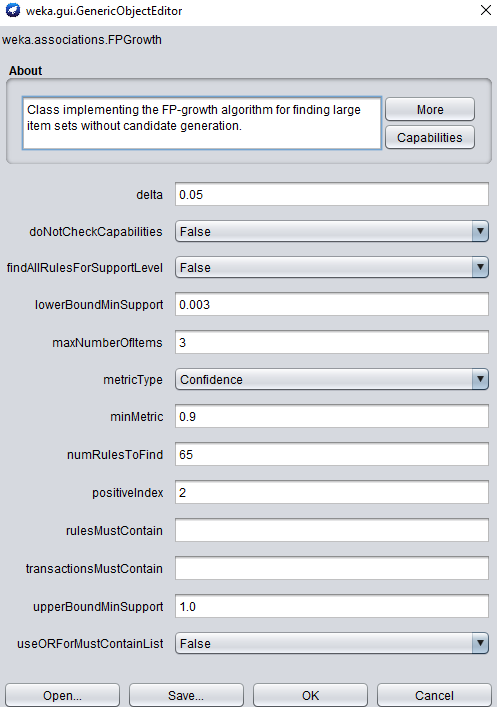

### FPGrowth Results

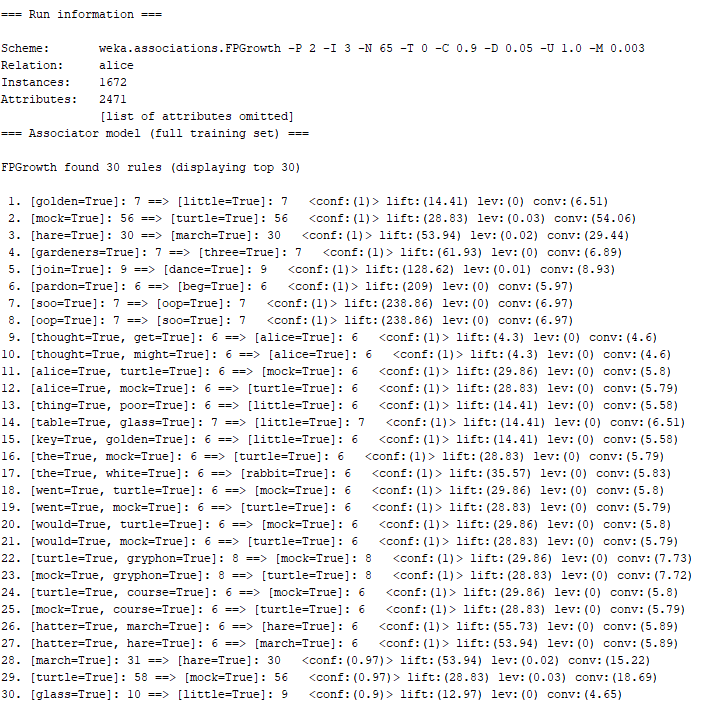

### Comments

These FPGrowth settings revealed both 'the White Rabbit' (number 17) and 'Mock Turtle' (number 2). 
It also finds 'pardon beg' and 'poor little thing.'

Most of the associations are related to names of characters in the story (White Rabbit, Mock Turtle and the Gryphon). Might be worth taking 'Alice' out of the dataset as a number of these relationships are established from Alice's musings about her acquaintances. 

I'm surprised that 'Queen of Hearts' doesn't show up in the results. I suppose it might with some more tuning either to the dataset or to Weka.

# 2.) MNIST NeuralNetworkMLP

Takes about 13 - 15 secs.

In [6]:
%%time

# Make NN
hidden_layers = (256, 256)
NN = MLPClassifier(hidden_layers)

# Cross-validate
kfold = KFold(n_splits=10)
scores = cross_val_score(NN, digit_data, digit_labels, cv=kfold, scoring='accuracy', n_jobs=4)
scores_str = ''
for idx, score in enumerate(scores):
    this_score = f'{score:.3f}'
    
    scores_str += this_score
    
    if idx < len(scores) - 1:
        scores_str += ', '
    
print(f'MLPClassifier with {len(hidden_layers)} hidden layers had accuracies {scores_str} in\n10-fold cross-validation.')

MLPClassifier with 2 hidden layers had accuracies 0.956, 1.000, 0.950, 0.983, 0.967, 0.989, 0.978, 0.983, 0.961, 0.944 in
10-fold cross-validation.
Wall time: 14.4 s
